**READ ME**

This must be run on a windows or linux machine. It is not guaranteed to work for macOS. The GPU must be compatible with Cuda 11.2 from my experience. It also must be run on python 3.10 at the time of writing this.

In [1]:
# All Libraries needed for this notebook
import tensorflow as tf
from keras import regularizers
from keras.callbacks import EarlyStopping
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
import pandas as pd
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'tensorflow'

In [3]:
# Setting the random seed so there is consistent data splitting between runs
tf.random.set_seed(42)
# importing the lowPPM matrix
allData = r"../Output/LowPPMMatrix.csv"

# Reading in the data to csv and removing any data at 150 ppm as this was incorrect data from testing
# NOTE: the 150 ppm is not in all outputs. but it is left in as a safeguard
df = pd.read_csv(allData)
df=df[df['Target PPM']!=150]
# Dropping all unneeded columns from the output
df = df.drop(columns=['Unnamed: 0','lowInterval','highInterval','Ratio'])
print(df.head())

# Declaring what sensor is used for the test set
test_sensor_id = 0  # Replace with the ID of the sensor you want in the test set
train_data = df[df['SensorID'] != test_sensor_id]
test_data = df[df['SensorID'] == test_sensor_id]

# Drop the SensorID column as we don't need it anymore
train_data = train_data.drop(columns=['SensorID'])
test_data = test_data.drop(columns=['SensorID'])
# Convert to TensorFlow tensors
train_data_tf = tf.convert_to_tensor(train_data, dtype=tf.float32)
test_data_tf = tf.convert_to_tensor(test_data, dtype=tf.float32)

   SensorID  Target PPM  Resistance  Temperature  RelativeHumidity
0       0.0         0.0   30.009404     0.795619          6.227832
1       3.0         0.0   28.086765     0.795619          6.227832
2       5.0         0.0   30.475486     0.795619          6.227832
3       7.0         0.0   31.911561     0.795619          6.227832
4       8.0         0.0   26.515605     0.795619          6.227832


In [4]:
# Randomizes the data for training to minimize fitting to false trends
train_data_shuffled = tf.random.shuffle(train_data_tf, seed=42)

# Separate features and labels
x_train, y_train = train_data_shuffled[:, 1:], train_data_shuffled[:, 0]
x_test, y_test = test_data_tf[:, 1:], test_data_tf[:, 0]

In [5]:
# Mean squared error function
def mse_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Root mean squared error function
def rmse(y_true, y_pred):
    return tf.sqrt(mse_loss(y_pred - y_true))

# R-Squared function to test fit of model
def r_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

# Used to trace history of RMSE as the neural network gets trained
class RMSEHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        if logs is None:
            logs = {}
        self.modelRMSE = []
        self.validationRMSE = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.modelRMSE.append(logs.get('rmse'))
        self.validationRMSE.append(logs.get('val_rmse'))

In [6]:
# Declare class as an instance
rmse_history = RMSEHistory()
# Compile and train the model
input_shape = (x_train.shape[1],)

Epoch 1/1000
11/11 [==============================] - 1s 18ms/step - loss: 809.2524 - r_squared: -1.6633 - rmse: 28.3977 - val_loss: 653.3250 - val_r_squared: -1.5480 - val_rmse: 25.5205
Epoch 2/1000
11/11 [==============================] - 0s 3ms/step - loss: 760.7366 - r_squared: -1.4438 - rmse: 27.4604 - val_loss: 615.5369 - val_r_squared: -1.3974 - val_rmse: 24.7559
Epoch 3/1000
11/11 [==============================] - 0s 3ms/step - loss: 722.6292 - r_squared: -1.3320 - rmse: 26.6322 - val_loss: 587.2538 - val_r_squared: -1.2846 - val_rmse: 24.1672
Epoch 4/1000
11/11 [==============================] - 0s 3ms/step - loss: 694.5020 - r_squared: -1.3020 - rmse: 26.2945 - val_loss: 565.1658 - val_r_squared: -1.1967 - val_rmse: 23.6982
Epoch 5/1000
11/11 [==============================] - 0s 3ms/step - loss: 671.7372 - r_squared: -1.1481 - rmse: 25.7960 - val_loss: 546.9963 - val_r_squared: -1.1243 - val_rmse: 23.3047
Epoch 6/1000
11/11 [==============================] - 0s 3ms/step - l

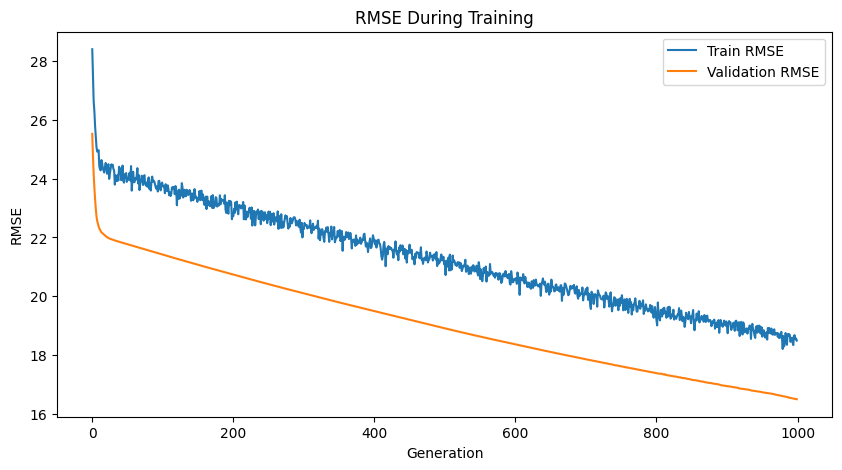

Epoch 1/200
11/11 [==============================] - 2s 21ms/step - loss: 347.1528 - r_squared: -0.1313 - rmse: 18.5650 - val_loss: 275.8103 - val_r_squared: -0.0629 - val_rmse: 16.4971
Epoch 2/200
11/11 [==============================] - 0s 4ms/step - loss: 346.9070 - r_squared: -0.1109 - rmse: 18.5373 - val_loss: 275.5695 - val_r_squared: -0.0620 - val_rmse: 16.4905
Epoch 3/200
11/11 [==============================] - 0s 4ms/step - loss: 346.6878 - r_squared: -0.1076 - rmse: 18.3966 - val_loss: 275.3742 - val_r_squared: -0.0612 - val_rmse: 16.4843
Epoch 4/200
11/11 [==============================] - 0s 4ms/step - loss: 346.5005 - r_squared: -0.1393 - rmse: 18.5385 - val_loss: 275.2246 - val_r_squared: -0.0606 - val_rmse: 16.4796
Epoch 5/200
11/11 [==============================] - 0s 4ms/step - loss: 346.3166 - r_squared: -0.1077 - rmse: 18.5369 - val_loss: 274.9942 - val_r_squared: -0.0598 - val_rmse: 16.4737
Epoch 6/200
11/11 [==============================] - 0s 4ms/step - loss: 3

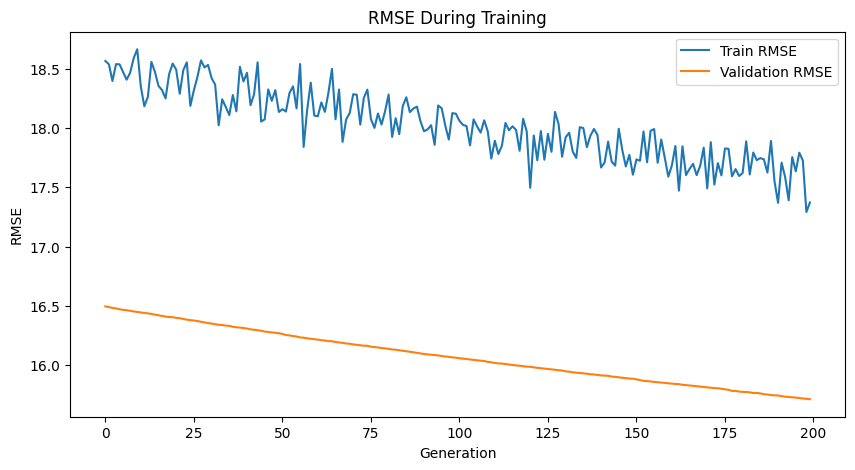

In [7]:

#Used to quickly change size of neural net
baseNum = 2

# Define your original model with regularization
def build_model(input_shape, regularization_factor=0.01):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(baseNum*2, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor), input_shape=input_shape),
        tf.keras.layers.Dense(baseNum*4, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(baseNum*4, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(baseNum*2, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
        # tf.keras.layers.Dense(baseNum, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(1)
    ])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

with tf.device('/GPU:0'):
    #regular model training
    model = build_model(input_shape)
    model.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])
    model.fit(x_train, y_train, epochs=1000, batch_size=50, validation_split=0.2, callbacks=[rmse_history])
    # if no improvement has been made in 100 generations (epochs) stop the model
    if early_stopping.stopped_epoch > 0:
        print(f"Early stopping occurred at epoch {early_stopping.stopped_epoch}")
        print(f"Restoring model weights from the end of the best epoch.")
    else:
        print("Early stopping did not occur.")

    test_metrics = model.evaluate(x_test, y_test)
    test_loss, test_accuracy, test_rmse = test_metrics[0], test_metrics[1], test_metrics[2]
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test Accuracy: {test_accuracy*100}")
    print(f"Test RMSE: {test_rmse}")
    # Plotting RMSE values
    plt.figure(figsize=(10, 5))
    plt.plot(rmse_history.modelRMSE, label='Train RMSE')
    plt.plot(rmse_history.validationRMSE, label='Validation RMSE')
    plt.xlabel('Generation')
    plt.ylabel('RMSE')
    plt.title('RMSE During Training')
    plt.legend()
    plt.show()

    # Pruning model. use the final_sparsity to trim the model. 0.5 means 50% of the nodes get trimmed, 0.9 means 90% of the nodes get trimmed. typically 0.6 is a good starting point for this
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.0,
                                                    final_sparsity=0.0,
                                                    begin_step=len(x_train) // 50 * 10,
                                                    end_step=len(x_train) // 50 * 500)
    }

    model_for_pruning = sparsity.prune_low_magnitude(model, **pruning_params)
    model_for_pruning.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared,rmse])

    callbacks = [
        sparsity.UpdatePruningStep(),
        early_stopping,
        rmse_history
    ]

    model_for_pruning.fit(x_train, y_train, epochs=200, batch_size=50, validation_split=0.2, callbacks=callbacks)

    # Remove the pruning wrappers to finalize the model
    final_model = sparsity.strip_pruning(model_for_pruning)


if early_stopping.stopped_epoch > 0:
    print(f"Early stopping occurred at epoch {early_stopping.stopped_epoch}")
    print(f"Restoring model weights from the end of the best epoch.")
else:
    print("Early stopping did not occur.")

# Make predictions
with tf.device('/GPU:0'):  # This line is optional
    test_metrics = model.evaluate(x_test, y_test)
    test_loss, test_accuracy, test_rmse = test_metrics[0], test_metrics[1], test_metrics[2]
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test Accuracy: {test_accuracy*100}")
    print(f"Test RMSE: {test_rmse}")


# Plotting RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_history.modelRMSE, label='Train RMSE')
plt.plot(rmse_history.validationRMSE, label='Validation RMSE')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.title('RMSE During Pruning')
plt.legend()
plt.show()
# model.save('MethaneModel.keras')

In [24]:
# Used to save the model
model.save('MethaneModelBest391-2nodes.keras')

13/13 [==============================] - 0s 2ms/step


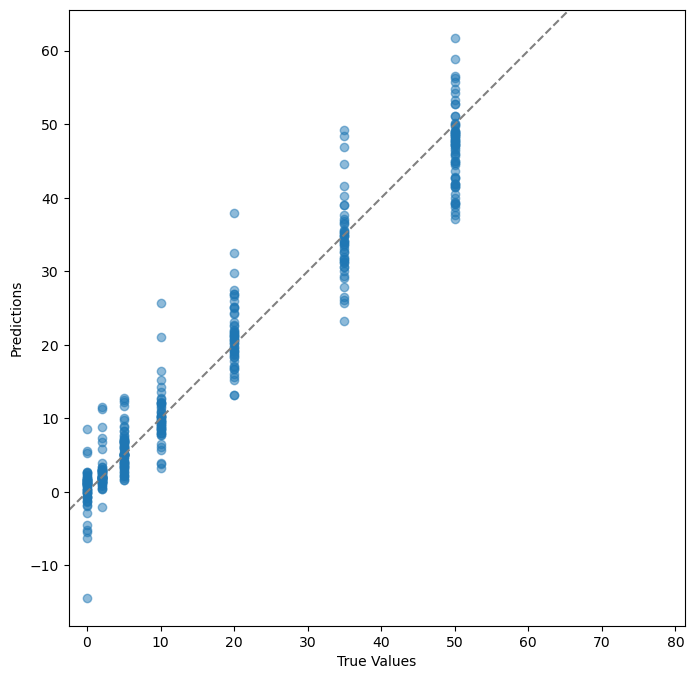

In [122]:
import matplotlib.pyplot as plt

# Generate predictions on the test data
with tf.device('/GPU:0'):  # Optional
    y_pred = model.predict(x_test)

# Flatten y_test and y_pred for plotting
y_test_flat = y_test.numpy().flatten()
y_pred_flat = y_pred.flatten()

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_flat, y_pred_flat, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')

# Plot a 45-degree line for reference
plt.plot([-100, 1200], [-100, 1200], '--', color='gray')

plt.show()


5/5 [==============================] - 0s 2ms/step


C:\Users\funkb\AppData\Local\Temp\ipykernel_4568\149973856.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Predicted PPM'] = y_pred
C:\Users\funkb\AppData\Local\Temp\ipykernel_4568\149973856.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Predicted PPM'] = y_pred
C:\Users\funkb\AppData\Local\Temp\ipykernel_4568\149973856.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

2/2 [==============================] - 0s 3ms/step


C:\Users\funkb\AppData\Local\Temp\ipykernel_4568\149973856.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Predicted PPM'] = y_pred


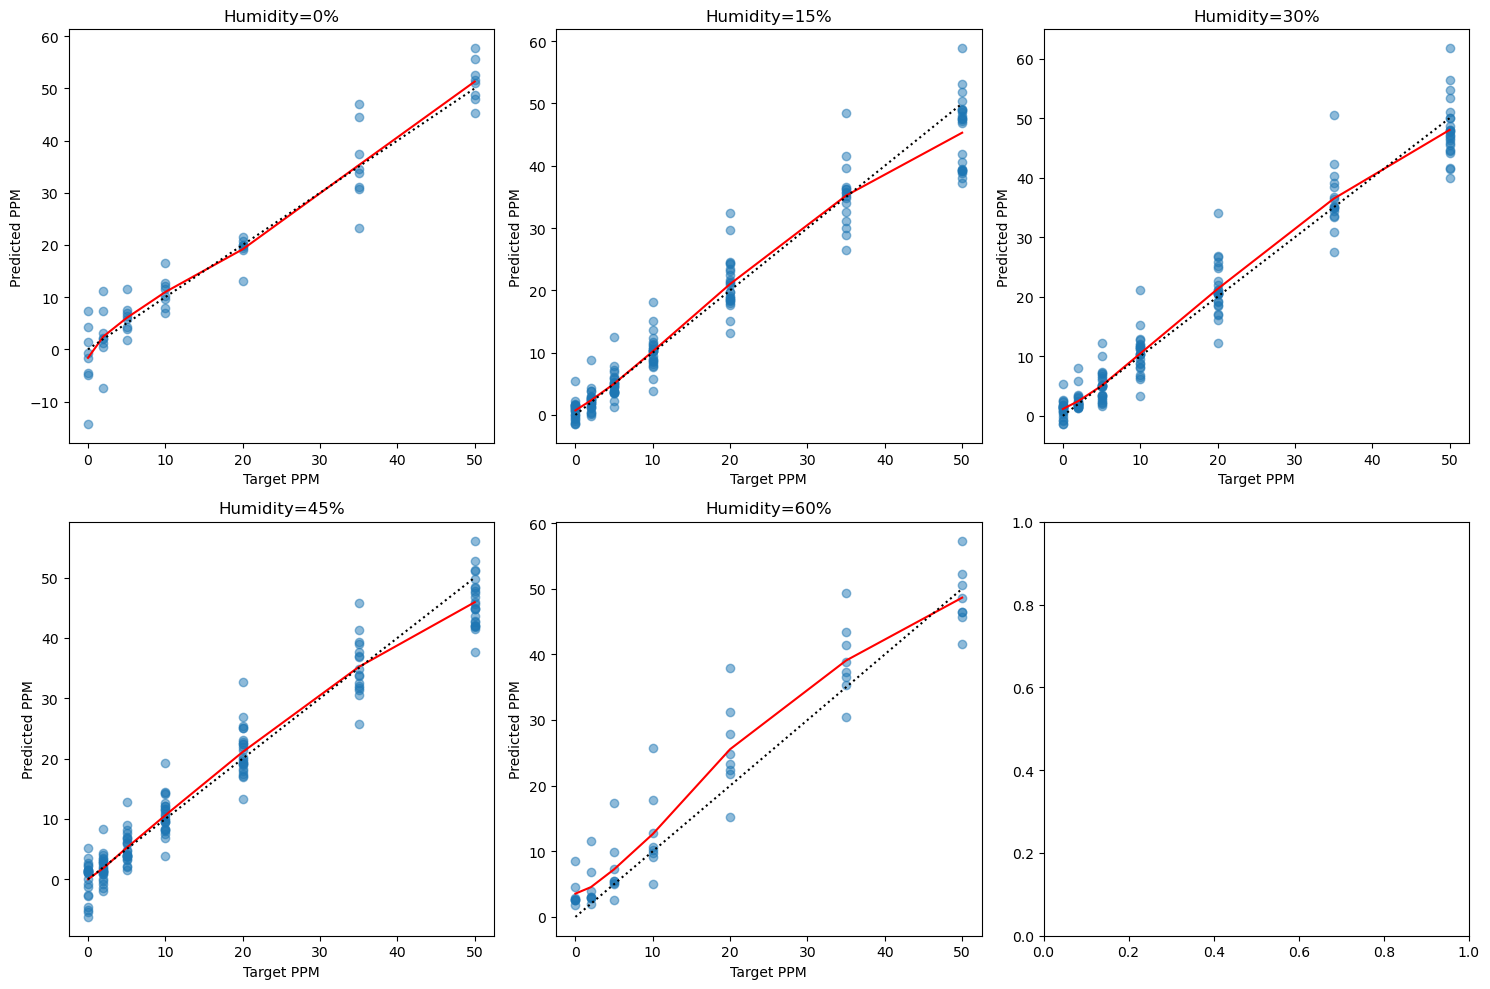

In [123]:
humidity_values = [0, 15, 30, 45, 60]  # Updated humidity values

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots

# Flatten the axs array in case it's 2D
axs = axs.flatten()

for i, H in enumerate(humidity_values):
    # Filter the data for the given humidity value
    mask = (df['RelativeHumidity'] >= H - 5) & (df['RelativeHumidity'] <= H + 5)
    df_filtered = df.loc[mask]

    xDataResistance1 = df_filtered.loc[:, 'Resistance']
    xDataTemp1 = df_filtered.loc[:, 'Temperature']
    xDataRH1 = df_filtered.loc[:, 'RelativeHumidity']
    yDataTargetPPM1 = df_filtered.loc[:, 'Target PPM']

    combined_df = pd.concat([xDataResistance1, xDataTemp1, xDataRH1], axis=1)


    with tf.device('/GPU:0'):  # Optional
          y_pred = model.predict(combined_df)  # Replace with your model's predict method
    df_filtered['Predicted PPM'] = y_pred

    # Create a scatter plot
    sc = axs[i].scatter(yDataTargetPPM1, y_pred, alpha=0.5)

    # Calculate mean prediction for each target PPM and plot it
    mean_pred_per_target_ppm = df_filtered.groupby('Target PPM')['Predicted PPM'].mean()
    axs[i].plot(mean_pred_per_target_ppm.index, mean_pred_per_target_ppm.values, color='r')

    # Add a linear dotted line for reference
    axs[i].plot(yDataTargetPPM1, yDataTargetPPM1, 'k:')

    axs[i].set_xlabel('Target PPM')
    axs[i].set_ylabel('Predicted PPM')
    axs[i].set_title(f'Humidity={H}%')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()